## Contents
* [1. Improved Models](#1.-Improved-Models)
* [2. Read & Clean Data](#2.-Read-&-Clean-Data)
* [3. Modelling](#3.-Modelling)
    * [3.1 ARIMA](#3.1-ARIMA)
    * [3.2 SARIMA](#3.2-SARIMA)

---
## 1. Improved Models
---
- To develop improved ARIMA and SARIMA models using a shorter 12-week prediction timeframe.

|         | Improved 3                           | Improved 4                                           |
|---------------|-----------------------------------|-----------------------------------------------------------------------------------------------|
| Model         | ARIMA                                | SARIMA                                               |
| Training data | - 2013 - 2022 Sep weekly dengue data | - 2013 - 2022 Sep weekly dengue data<br>- Season = 4 |
| Testing data  | year of 2022            | Oct - Dec 2022 (12 weeks)                            |

---
## 2. Read & Clean Data
---

### Loading of Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Auto ARIMA imports
import pmdarima as pm # to do Auto ARIMA  
from pmdarima.arima import ADFTest # to perform ADF test 
from sklearn.metrics import mean_absolute_percentage_error # metric to evaluate time series model

# import ACF plot from statsmodels
from statsmodels.graphics.tsaplots import plot_acf

### Load Data and Preprocessing
- Filter data from 2013 to 2022
- Check data types and null values
  - Change date to correct datetime format
  - Rename columns
- Set index to be the date column 
- Ascending sort on the index: 'date' from earliest to latest

#### Weekly Dengue Data - 2013 to 2022

In [12]:
# loading data
weekly_dengue = pd.read_csv('./Dengue_Data_Collection 2/Dengue_weekly.csv')

print(weekly_dengue.shape)
weekly_dengue.head()

(574, 6)


Epidemiology Wk       Start         End  Dengue  DHF  month_year
0              1.0  2012-01-01  2012-01-07      74    0  2012-01-01
1              2.0  2012-01-08  2012-01-14      64    2  2012-01-01
2              3.0  2012-01-15  2012-01-21      60    1  2012-01-01
3              4.0  2012-01-22  2012-01-28      50    2  2012-01-01
4              5.0  2012-01-29  2012-02-04      84    1  2012-01-01

In [13]:
# Filter data from 2013 to 2022
weekly_dengue = weekly_dengue.iloc[52:]
print(weekly_dengue.head())
weekly_dengue.tail()

    Epidemiology Wk       Start         End  Dengue  DHF  month_year
52              1.0  2012-12-30  2013-01-05     132    2  2012-12-01
53              2.0  2013-01-06  2013-01-12     204    1  2013-01-01
54              3.0  2013-01-13  2013-01-19     219    0  2013-01-01
55              4.0  2013-01-20  2013-01-26     264    3  2013-01-01
56              5.0  2013-01-27  2013-02-02     292    1  2013-01-01


Epidemiology Wk       Start         End  Dengue  DHF  month_year
569             48.0  2022-11-27  2022-12-03     242    0  2022-11-01
570             49.0  2022-12-04  2022-12-10     326    1  2022-12-01
571             50.0  2022-12-11  2022-12-17     289    1  2022-12-01
572             51.0  2022-12-18  2022-12-24     272    0  2022-12-01
573             52.0  2022-12-25  2022-12-31     285    0  2022-12-01

In [14]:
# Check data types and null values
weekly_dengue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 52 to 573
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Epidemiology Wk  522 non-null    float64
 1   Start            522 non-null    object 
 2   End              522 non-null    object 
 3   Dengue           522 non-null    int64  
 4   DHF              522 non-null    int64  
 5   month_year       522 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 24.6+ KB


There are no null values.

In [15]:
# Change 'Start' col data type to the correct format
weekly_dengue['Start'] = pd.to_datetime(weekly_dengue['Start'])

In [16]:
# Extract 'Start' and 'Dengue' col only
weekly_dengue = weekly_dengue[['Start', 'Dengue']]
weekly_dengue.head()

Start  Dengue
52 2012-12-30     132
53 2013-01-06     204
54 2013-01-13     219
55 2013-01-20     264
56 2013-01-27     292

In [17]:
# Rename col names
weekly_dengue.rename(columns={'Start':'date', 'Dengue':'dengue'}, inplace=True)

In [18]:
# Check data types and col names
weekly_dengue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 52 to 573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    522 non-null    datetime64[ns]
 1   dengue  522 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.3 KB


In [19]:
# Set index to be the date column 
weekly_dengue = weekly_dengue.set_index('date')

In [20]:
# Ascending sort on the index: 'date' from earliest to latest
weekly_dengue = weekly_dengue.sort_index()

In [21]:
# Check dataset
weekly_dengue.head()

dengue
date              
2012-12-30     132
2013-01-06     204
2013-01-13     219
2013-01-20     264
2013-01-27     292

### EDA
- Plot the total dengue cases across months
- Confirm stationarity of dataset

#### Weekly Dengue Data - 2013 to 2022

In [22]:
# Define a function to plot the total dengue cases over time
def plot_series(df, col, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
               
    # Generate a line plot of the column name.
    plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

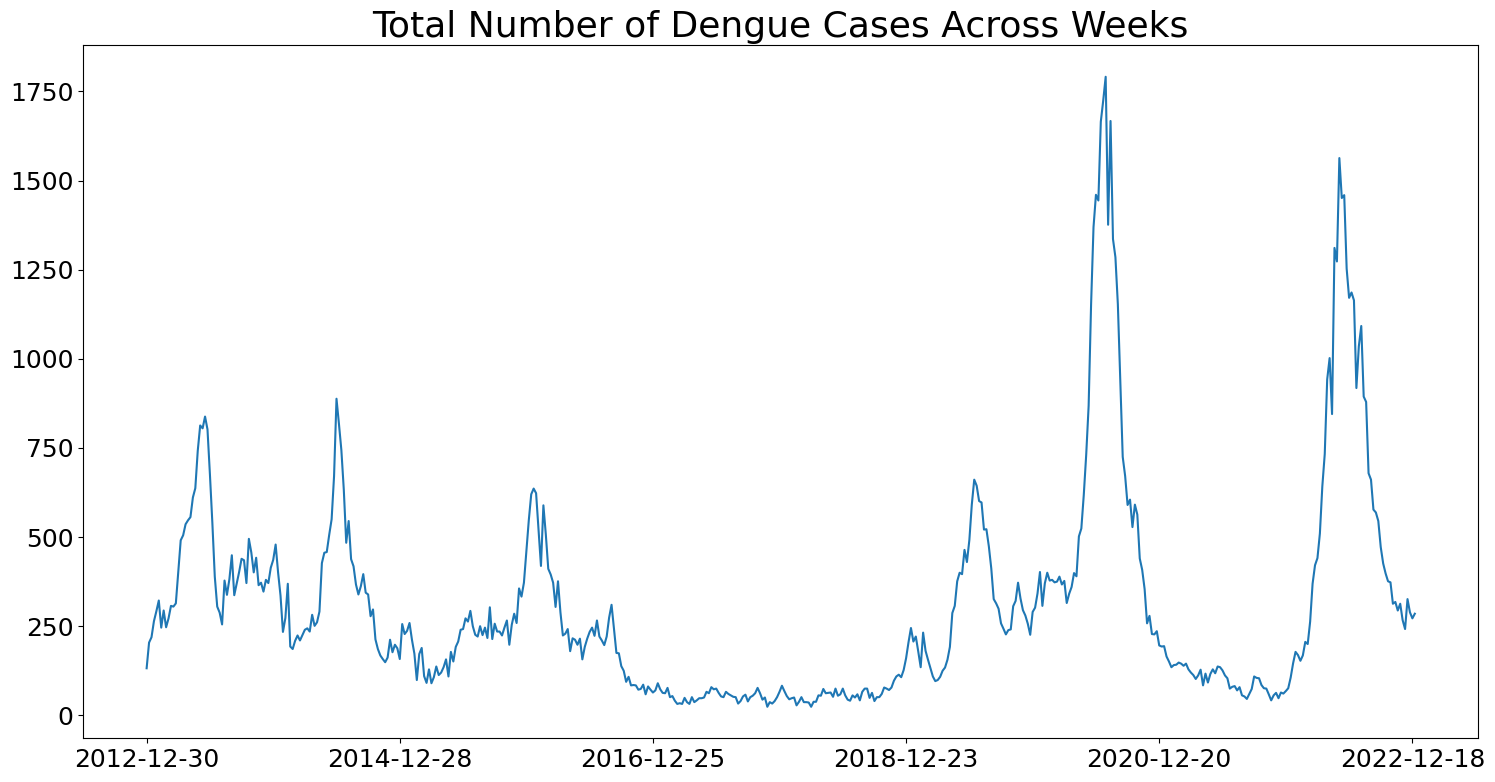

In [23]:
plot_series(weekly_dengue, 'dengue', title='Total Number of Dengue Cases Across Weeks', steps = 104)

In [24]:
# Augmented Dickey-Fuller test on our weekly data as that was ambiguous to confirm stationarity
adf_test = ADFTest(alpha = 0.05) # instantiate ADF test with setting the threshold for p-value to accept/reject null hypothesis

# ADF test run using this function to tell should the df.diff() be called or not on the data passed
adf_test.should_diff(weekly_dengue['dengue']) 

(0.01, False)

- Since p-value < 0.05, we can reject the null hypothesis that dataset is non-stationary, i.e. dataset is stationary and .diff() is not needed.

---
## 3. Modelling
---
- Train/test split
- Model fitting
- Model summary
- Find and plot predictions to compare vs y_test

## 3.1 ARIMA
- Weekly Dengue Data using ARIMA model - 2013 to 2022

In [25]:
# Train/test split in 90/10
y_train, y_test = train_test_split(weekly_dengue['dengue'], test_size=.1, shuffle=False)  

In [26]:
# Instantiate and fit ARIMA model
arima_model = pm.AutoARIMA(start_p=0, max_p=10,  # max 10 months
                           d=None,    # find optimum value of d automatically
                           start_q=0, max_q=10,  # max 10 previous error
                           trace=True, # Print values in console for each fit in the grid search
                           random_state=20, # repeatability of steps in the same order
                           )

arima_model.fit(y_train) # only fit on the one column that we have, y_train2

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6575.268, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5156.007, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6089.042, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6905.892, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=5156.343, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5156.994, Time=0.49 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5154.588, Time=0.64 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=5094.916, Time=0.87 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=5108.359, Time=0.38 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=5096.214, Time=1.33 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=5095.824, Time=1.16 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5094.386, Time=0.66 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5118.419, Time=0.60 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=5096.052, Time=0.76 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept

AutoARIMA(max_p=10, max_q=10, random_state=20, start_p=0, start_q=0, trace=True)

- The best model with Auto ARIMA is ARIMA(2,0,2)(0,0,0)[0] intercept.
- As with the result from the Augmented Dickey-Fuller test, optimum value of d is 0.

In [27]:
# Print summary results
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  469
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -2541.193
Date:                Fri, 10 Feb 2023   AIC                           5094.386
Time:                        13:33:04   BIC                           5119.290
Sample:                    12-30-2012   HQIC                          5104.185
                         - 12-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.6095      2.394      2.343      0.019       0.916      10.302
ar.L1          1.7221      0.047     37.001      0.000       1.631       1.813
ar.L2         -0.7435      0.046    -16.071      0.000      -0.834      -0.653
ma.L1         -0.7728      0.051    -15.074      0.000      -0.873      -0.672
ma.L2          0.2824      0.026     11.035      0.000       0.232       0.333
sigma2      2955.1080     93.857     31.485      0.000    2771.152    3139.064
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1942.40
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             0.04
Prob(H) (two-sided):                  0.09   Kurtosis:                        12.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Based on `ar.L1` and `ar.L2`, the value of `y` at any given point in time is correlated to its value at the immediate previous time stamp (1 week before) with a coefficient of `~1.72` and immediate 2 time steps back (2 weeks before) with a coefficient of `~-0.74`.

##### Making and Plot Predictions

In [28]:
# Define function to find and plot predictions to compare vs y_test
def plot_forecast(y_train, y_test, arima_model, title, X_test=None):
    # Generate len(y_test) number of predictions
    y_pred = arima_model.predict(n_periods = len(y_test), X=X_test) # we want as many future data point predictions as there are in y_test

    # Plot data
    plt.figure(figsize=(30,15))

    # Plot training data
    plt.plot(y_train, color='blue', label='y_train')

    # Plot testing data
    plt.plot(y_test, color='orange', label='y_test', alpha = 0.7)  # alpha is to set transparency

    # Plot predicted test values
    plt.plot(y_test.index, y_pred.values, color='green', label='y_pred', alpha = 0.9, ls = '--')

    # Find the MAPE (mean abs percentage error) of the predictions
    mape = mean_absolute_percentage_error(y_test, y_pred)

    plt.title(label = f'{title}\n MAPE: {mape:.2f}', fontsize=26)
    plt.legend(fontsize = 24, loc = 'upper left')
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20);

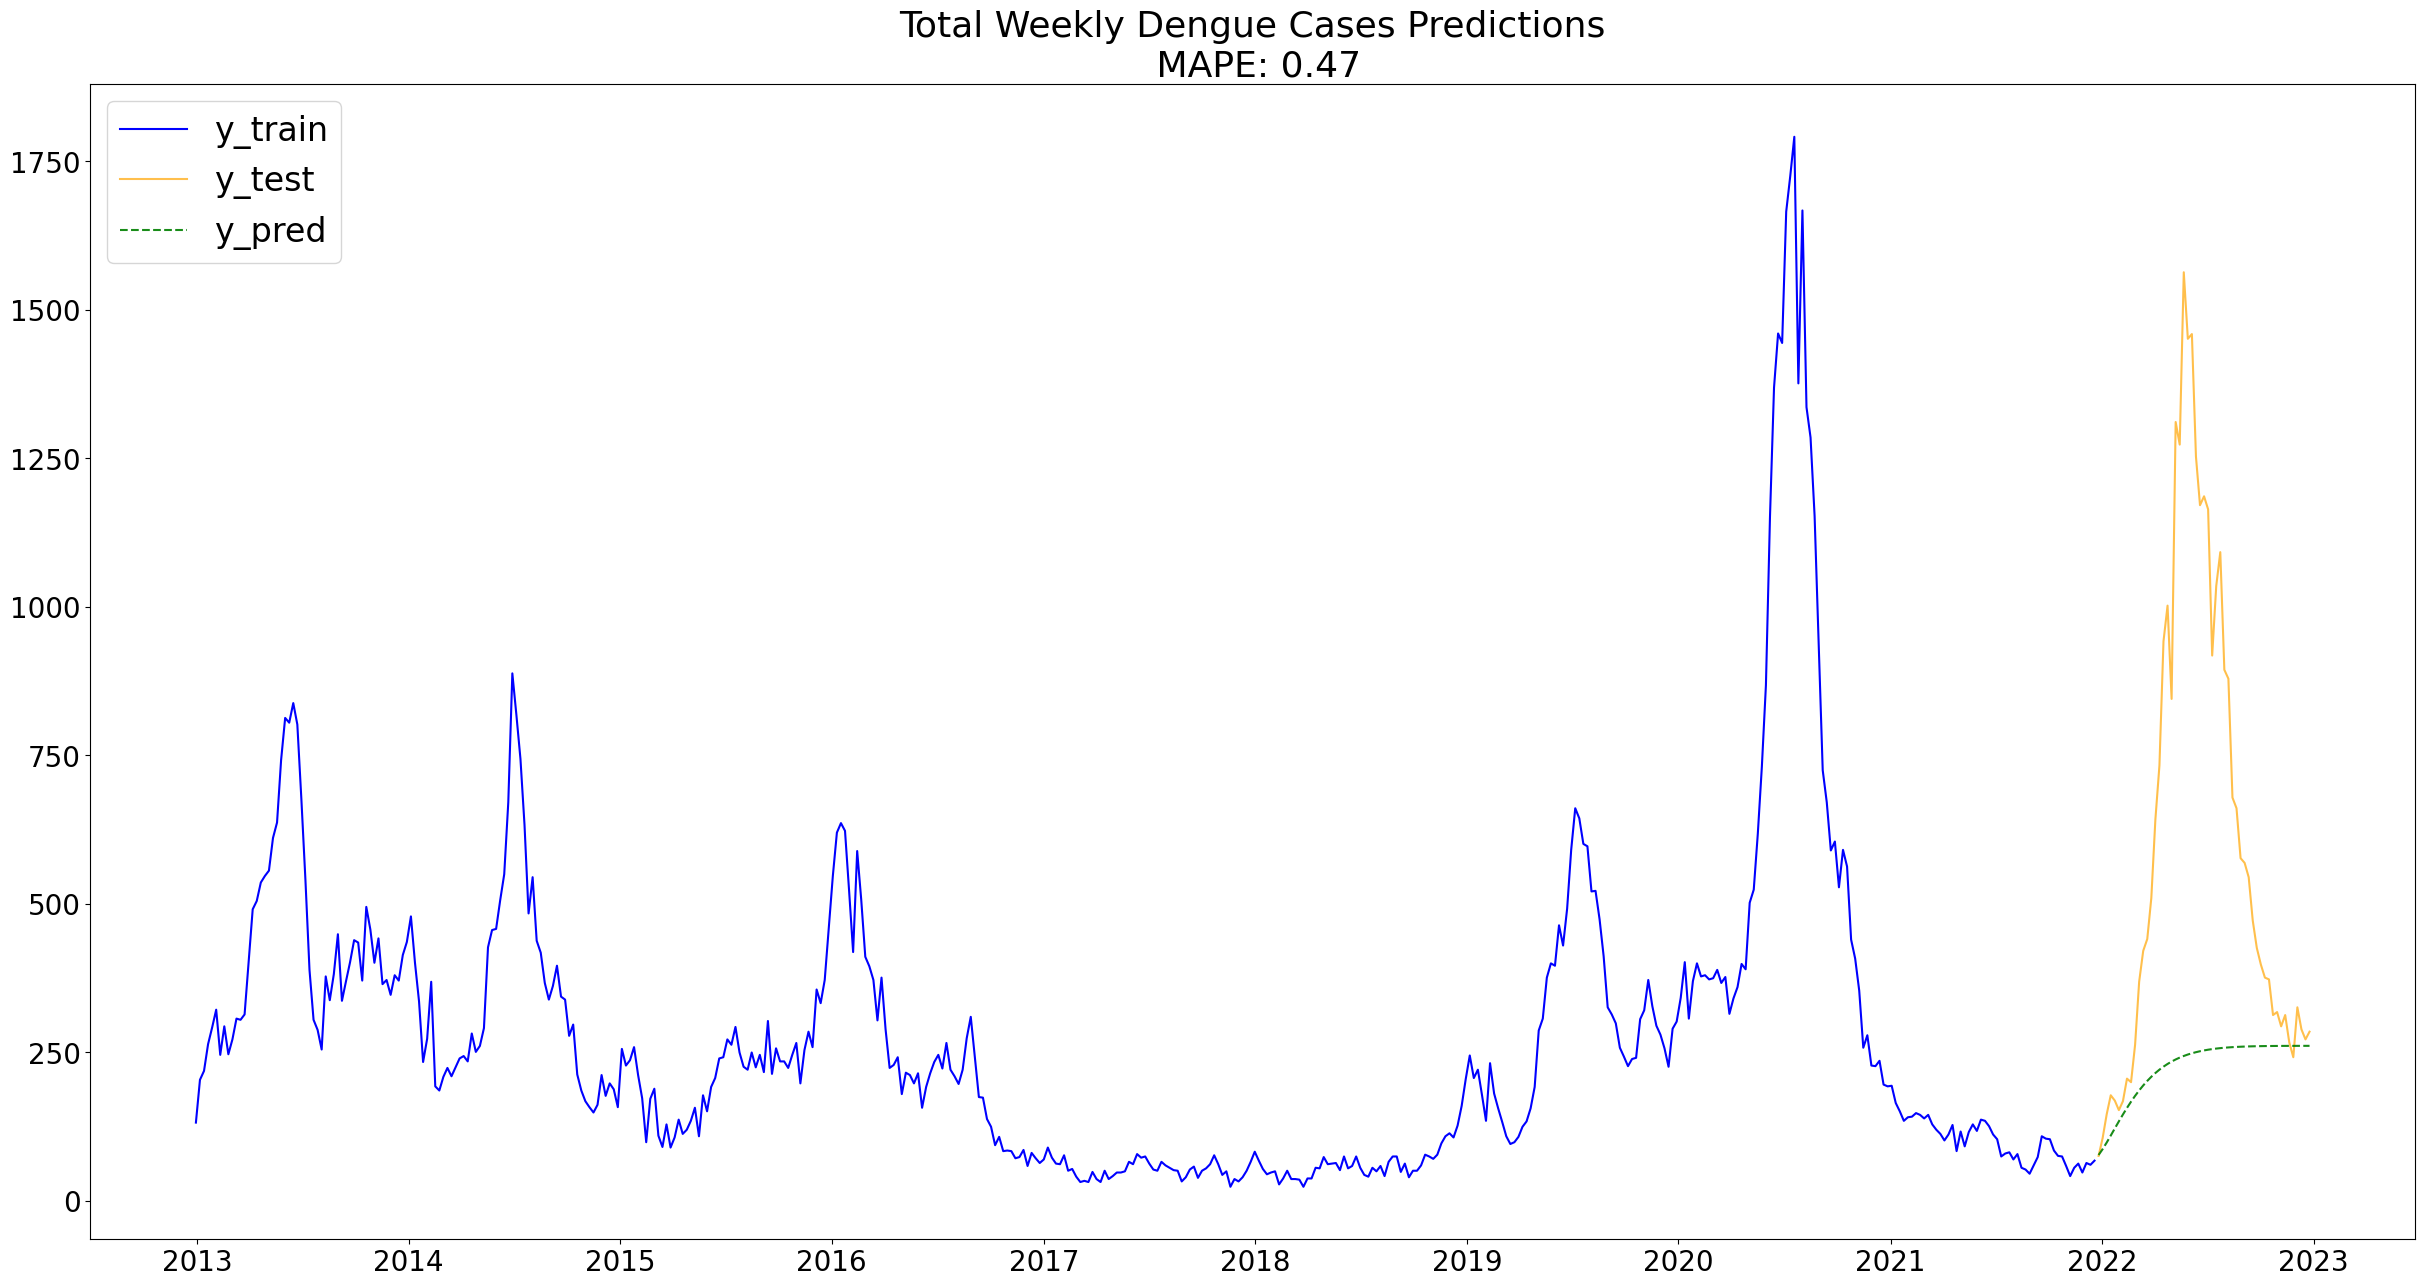

In [29]:
plot_forecast(y_train, y_test, arima_model, title='Total Weekly Dengue Cases Predictions')

- MAPE for ARIMA model using weekly dengue cases is 0.47.
- We will move on to check for seasonality in dataset and fit SARIMA model.

## 3.2 SARIMA
- Weekly Dengue Data using SARIMA model - 2013 to 2022 - 12 weeks prediction

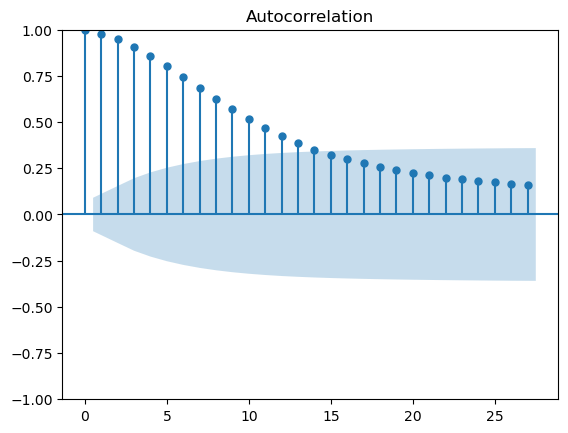

In [30]:
# Generate autocorrelation plot on training data.
plot_acf(y_train);

- From the autocorrelation plot, there seems to be a seasonlity of 2 to 14.
- We will fit SARIMA model with these values of seasonality and find the model with the best MAPE.
- Below is the best SARIMA model with S=4.

In [31]:
# Fit Auto SARIMA with S=4
arima_model2 = pm.AutoARIMA(
                           # same parameters as Auto ARIMA
                           start_p=0, max_p=10, # we specify the start and end for our grid search
                           d=None,    # let Auto ARIMA automatically find optimum value of d automatically
                           start_q=0, max_q=10, # we specify the start and end for our grid search
                           
                           # uncomment these hyperparameter declarations to train SARIMA model this time
                           start_P=0, max_P=10, # tune `P` SARIMA hyperparameter between 0 to 10 same as `p`
                           D=None,    # let Auto ARIMA automatically find optimum value of D automatically
                           start_Q=0, max_Q=10, # tune `Q` SARIMA hyperparameter between 0 to 10 same as `q`
                           m=4, # this is the `S`! Since the peak occurs every 3 months!
                           seasonal=True, # HAS to be set to True to use `m`. goes in conjunction with `m`
                           
                           # same parameters as Auto ARIMA
                           trace=True, # Print values for each fit in the grid search
                          )

arima_model2.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=6575.268, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=5148.168, Time=0.37 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=5756.571, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=6905.892, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=5156.007, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=5149.993, Time=1.38 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=5150.109, Time=0.97 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=5148.401, Time=0.50 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=5146.771, Time=1.12 sec
 ARIMA(1,0,0)(3,0,1)[4] intercept   : AIC=5144.110, Time=1.83 sec
 ARIMA(1,0,0)(3,0,0)[4] intercept   : AIC=5142.062, Time=1.94 sec
 ARIMA(1,0,0)(4,0,0)[4] intercept   : AIC=5144.064, Time=3.05 sec
 ARIMA(1,0,0)(4,0,1)[4] intercept   : AIC=5146.043, Time=3.16 sec
 ARIMA(0,0,0)(3,0,0)[4] intercept   : AIC=5864.831, Time=2.19 sec
 ARIMA(2,0,0)(3,0,0)[4] intercept

AutoARIMA(m=4, max_P=10, max_Q=10, max_p=10, max_q=10, start_P=0, start_Q=0,
          start_p=0, start_q=0, trace=True)

- The best model with Auto ARIMA is ARIMA(3,0,1)(3,0,0)[4] intercept.

In [32]:
# Print summary results
arima_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  469
Model:             SARIMAX(3, 0, 1)x(3, 0, [], 4)   Log Likelihood               -2539.293
Date:                            Fri, 10 Feb 2023   AIC                           5096.585
Time:                                    13:47:36   BIC                           5133.941
Sample:                                12-30-2012   HQIC                          5111.283
                                     - 12-19-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.7091      2.951      2.274      0.023       0.926      12.492
ar.L1          1.3726      0.081     16.966      0.000       1.214       1.531
ar.L2         -0.0868      0.097     -0.891      0.373      -0.278       0.104
ar.L3         -0.3077      0.028    -10.911      0.000      -0.363      -0.252
ma.L1         -0.4227      0.085     -4.978      0.000      -0.589      -0.256
ar.S.L4        0.0120      0.036      0.337      0.736      -0.058       0.082
ar.S.L8       -0.0277      0.047     -0.594      0.553      -0.119       0.064
ar.S.L12      -0.0993      0.052     -1.896      0.058      -0.202       0.003
sigma2      2890.4375    104.538     27.650      0.000    2685.546    3095.329
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1805.26
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             0.16
Prob(H) (two-sided):                  0.13   Kurtosis:                        12.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Based on `ar.L1`, `ar.L2` and `ar.L3`, the value of `y` at any given point in time is correlated to its value at the immediate previous time stamp (1 week before) with a coefficient of `~1.37`, immediate 2 time steps back (2 weeks before) with a coefficient of `~-0.09`, and immediate 3 time steps back (3 weeks before) with a coefficient of `~-0.31`.

##### Making and Plot Predictions

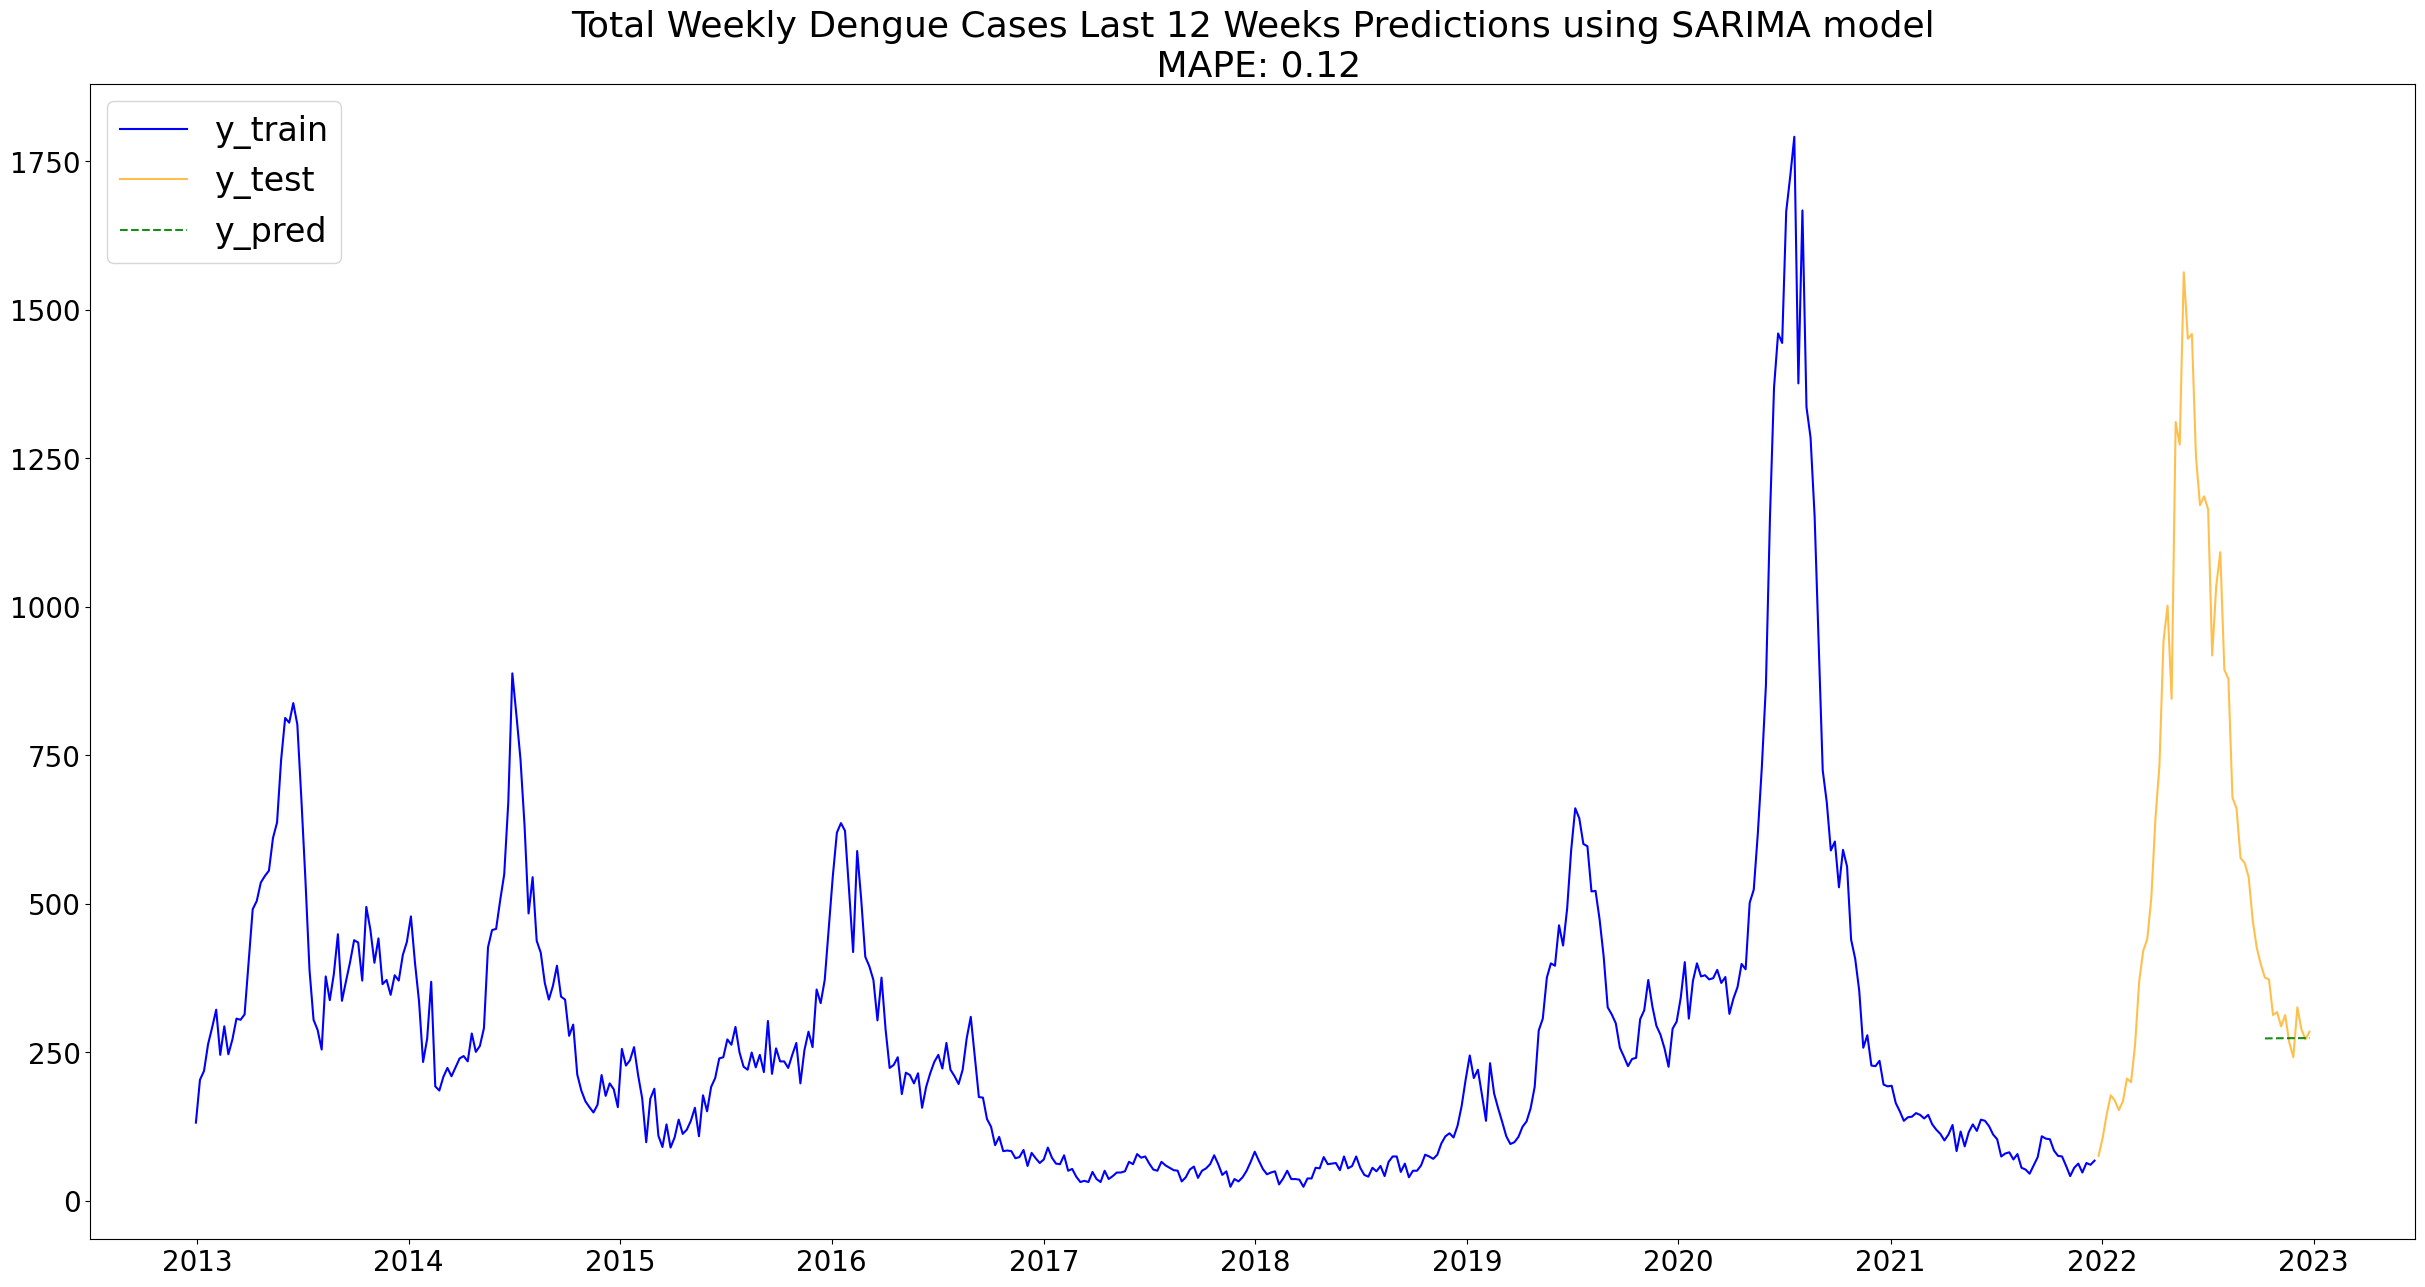

In [36]:
# Generate last 12 weeks of predictions
y_pred2 = arima_model2.predict(n_periods = 53).iloc[-12:] 

# Plot data
plt.figure(figsize=(30,15))

# Plot training data
plt.plot(y_train, color='blue', label='y_train')

# Plot testing data
plt.plot(y_test, color='orange', label='y_test', alpha = 0.7)  # alpha is to set transparency

# Plot predicted test values
plt.plot(y_pred2.index, y_pred2.values, color='green', label='y_pred', alpha = 0.9, ls = '--')

# Find the MAPE (mean abs percentage error) of the predictions
mape = mean_absolute_percentage_error(y_test.iloc[-12:], y_pred2)

title = 'Total Weekly Dengue Cases Last 12 Weeks Predictions using SARIMA model'

plt.title(label = f'{title}\n MAPE: {mape:.2f}', fontsize=26)
plt.legend(fontsize = 24, loc = 'upper left')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20);

- SARIMA with S=4 is able to predict the total weekly dengue cases in the last 12 weeks at a MAPE of 0.12.

| Models        | Improved 3                           | Improved 4<br>\*Best performance\*                                           |
|-----------------------------------------------------------------------------------------------|--------------------------------------|------------------------------------------------------|
| Model         | ARIMA                                | SARIMA                                               |
| Training data | - 2013 - 2022 Sep weekly dengue data | - 2013 - 2022 Sep weekly dengue data<br>- Season = 4 |
| Testing data  | year of 2022           | Oct - Dec 2022 (12 weeks)                            |
| MAPE score    | 0.47                                 | 0.12                                                 | 